# Import modules

In [1]:
import os
import cv2
import time
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import confusion_matrix

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler

import torchvision.transforms as T
import torchvision.models as models
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

from matplotlib import pyplot as plt
from dataloader import *

In [2]:
# Utility to apply transforms
def get_transform():
  mean = (127.5)
  std = (127.5)
  normalize = T.Normalize(mean=mean, std=std)
  return T.Compose([normalize])

In [3]:
name = 'models'

try:
    os.makedirs(os.path.join(os.getcwd(), f'{name}'))
except FileExistsError:
    print("Directory already exists!")
    pass

modelDir = os.path.join(os.getcwd(), f'{name}')

Directory already exists!


In [4]:
# Testing function
def evaluate_model(model, test_loader):
  model.eval()
  predicted_correctly_on_epoch = 0
  total = 0
  best_acc = 0.0
  acc = []
  device = set_device()

  with torch.no_grad():
    for data in test_data_loader: 
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      total += labels.size(0)

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)

      predicted_correctly_on_epoch += (predicted == labels).sum().item()
  
  epoch_acc = 100.0 * predicted_correctly_on_epoch / total
  acc.append(epoch_acc)

  if epoch_acc > best_acc:
    best_acc = epoch_acc
    torch.save(model.state_dict(), os.path.join(modelDir, 'best_model.pth'))

  print("  - Testing dataset: Got %d out of %d images correctly (%.3f%%)"
        % (predicted_correctly_on_epoch, total, epoch_acc))
  
  return acc

# Define the model

In [5]:
# # for resnet
# model = models.resnet18(pretrained=True)
# num_features = model.fc.in_features
# num_classes = 4
# model.fc = nn.Linear(num_features, num_classes)
# print(model)

# for mobilenet
model = models.mobilenet_v2(pretrained=True)
num_features = model.classifier[1].in_features
num_classes = 4
model.classifier[1] = nn.Linear(num_features, num_classes)
print(model)

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [6]:
from PIL import Image

# Define labels
classes = ['head_left', 'head_right', 'none', 'standing']

In [7]:
# Load the trained model

model = model
#state_dict = torch.load(os.path.join(modelDir, 'best_model.pth')) # for GPU
state_dict = torch.load(os.path.join(modelDir, 'best_model.pth'), map_location=torch.device('cpu')) # for CPU
model.load_state_dict(state_dict)

<All keys matched successfully>

In [8]:
# We don't need gpu for inference
device = torch.device("cpu")
model.to(device)

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [9]:
def classify_fancy(model, image_transforms, images_path, classes):
  model = model.eval()
  offset = 30
  for image in os.listdir(images_path):
    img = cv2.imread(os.path.join(images_path, image), 1)
    dimension = img.shape
    height = dimension[1] 
    width = dimension[0] 

    img = torch.from_numpy(img)
    img = img.permute(2, 0, 1)    
    img = img.unsqueeze(0)
    img = img.float()
    img = image_transforms(img)

    output = model(img)
    _, prediction = torch.max(output.data, 1)

    predicted_class = classes[prediction.item()]

    img = img.permute(0,2,3,1)
    img = img.numpy()

    if (predicted_class == 'head_left'):
      x = width / 2 + offset
      y = height / 3 + offset - 10

      plt.arrow(x, y, -75, 0, width = 10)
      plt.imshow((img[0] * 255).astype(np.uint8), cmap='gray')
      plt.title(f'Prediction: {predicted_class}')
      plt.show()

    elif (predicted_class == 'head_right'):
      x = width / 2 + offset
      y = height / 3 + offset - 10

      plt.arrow(x, y, 75, 0, width = 10)
      plt.imshow((img[0] * 255).astype(np.uint8), cmap='gray')
      plt.title(f'Prediction: {predicted_class}')
      plt.show()

    elif (predicted_class == 'standing'):
      x = width / 2 + offset
      y = height / 3 + offset - 10

      plt.arrow(x, y, 0, -75, width = 10)
      plt.imshow((img[0] * 255).astype(np.uint8), cmap='gray')
      plt.title(f'Prediction: {predicted_class}')
      plt.show()

    else:
      plt.imshow((img[0] * 255).astype(np.uint8), cmap='gray')
      plt.title(f'Prediction: {predicted_class}')
      plt.show()

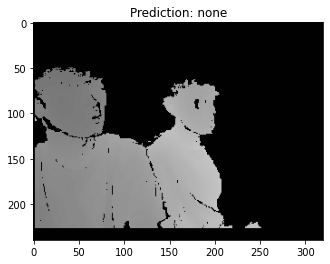

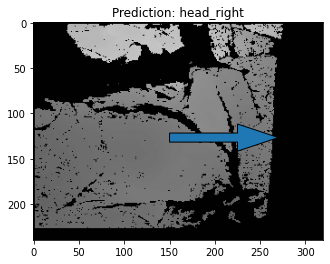

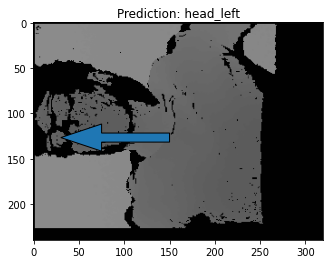

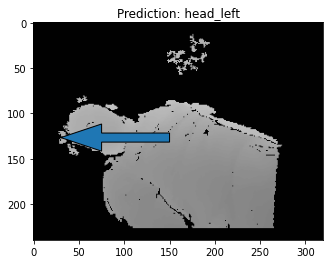

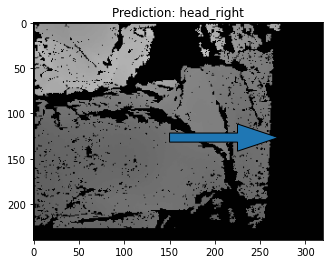

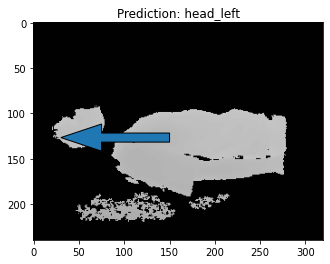

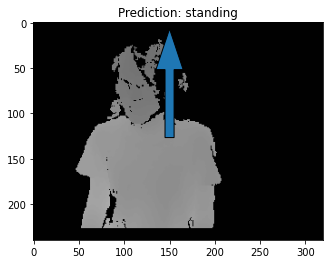

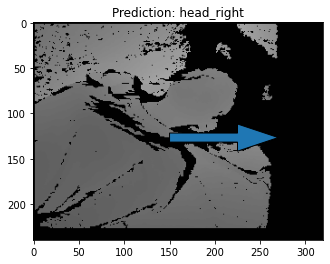

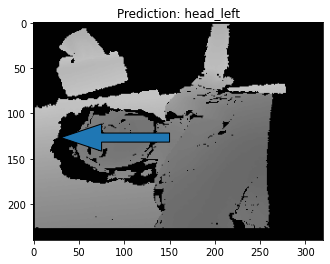

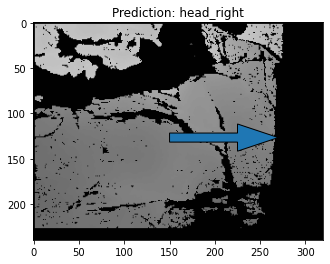

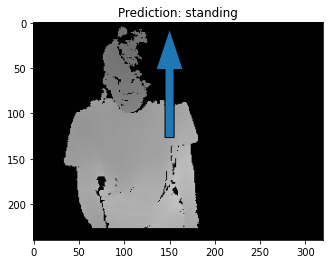

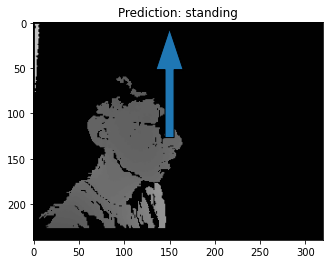

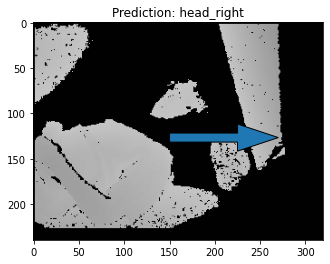

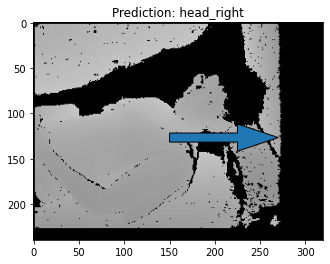

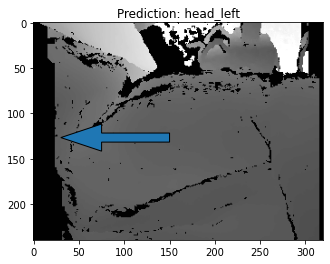

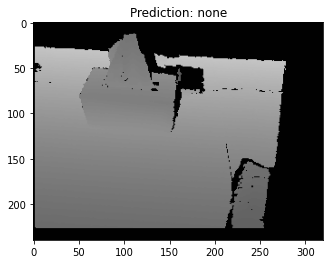

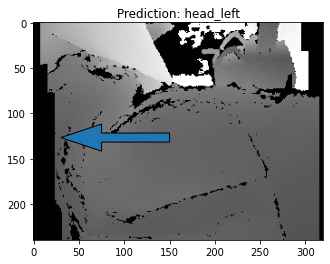

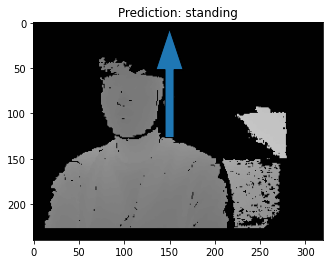

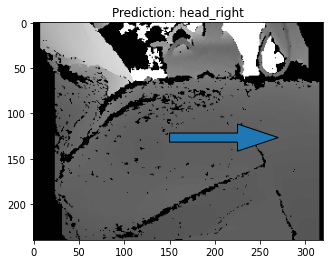

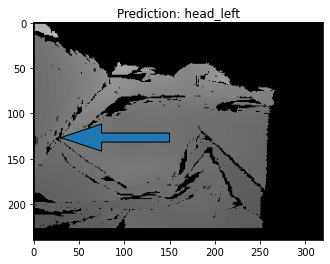

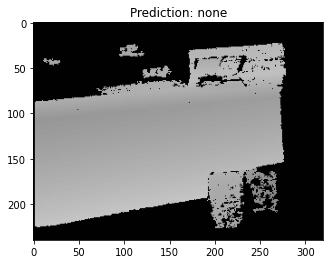

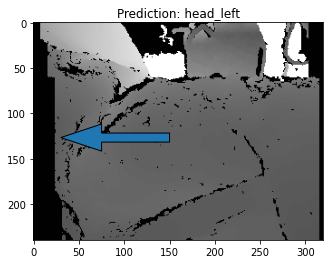

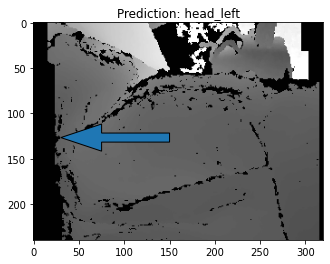

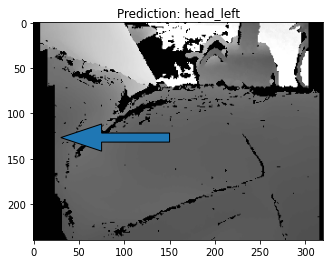

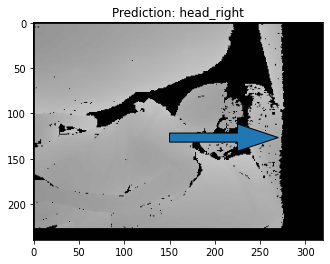

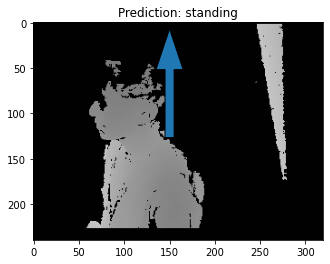

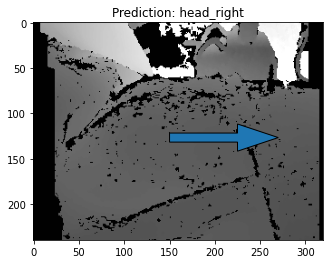

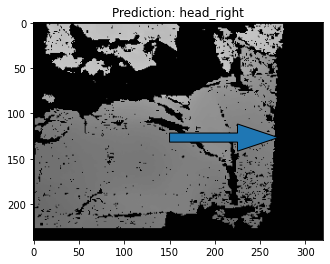

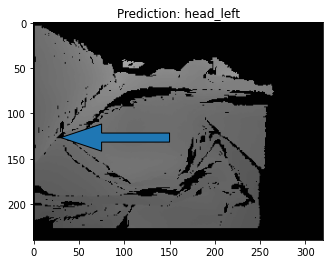

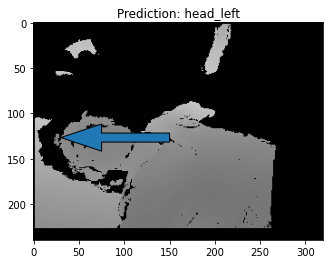

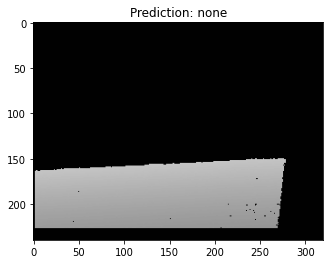

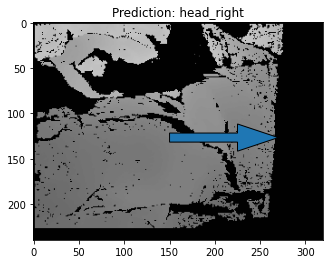

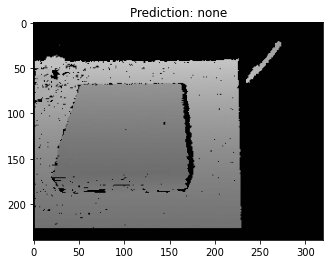

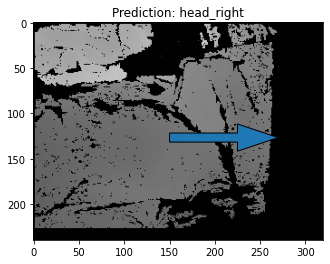

In [10]:
classify_fancy(model, get_transform(), '../dataset/test_prediction', classes)